In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Define the file path to the dataset
file_path = r"C:\Users\user\OneDrive\Documents\M2 SNS IDS\HAH913E - Santé activité physique 5\FemmeCardio.csv"

# Load the dataset into a Pandas DataFrame
data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

# Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Handle invalid dates

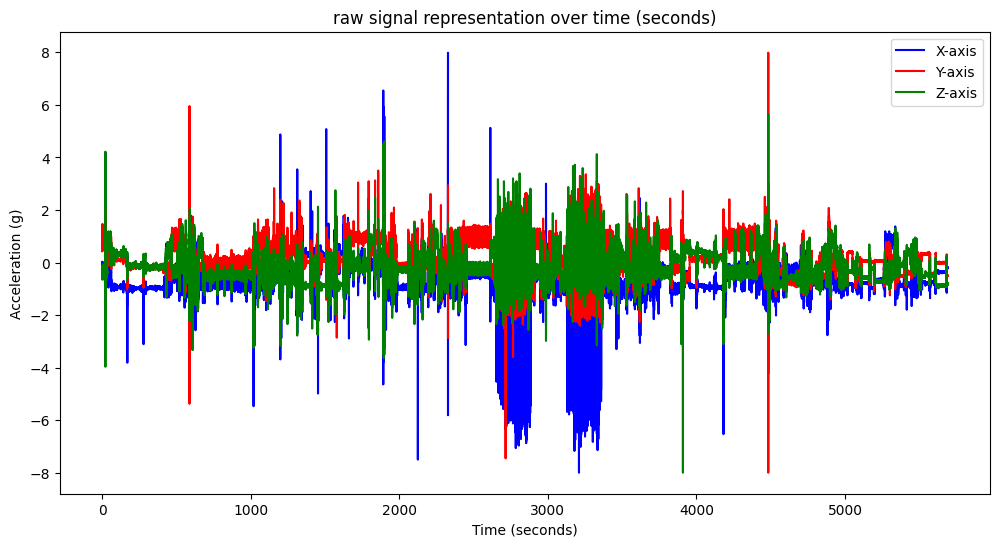

In [ ]:

# Calculate the sampling interval (in seconds) based on the time difference between two consecutive rows
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  # Access a single row
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()
# Create a new column for relative time in seconds, using the data index and sampling interval
data['relative_time_seconds'] = data.index * sampling_interval

# Define labels for the X, Y, and Z axes 
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'skyblue', 'Y': 'orange', 'Z': 'lightgreen'}  # Define colors for each signal

# Plot the signal with the correct label and color to each axis. using a loop
plt.figure(figsize=(12, 6))
for signal, axis_label, color in zip(signal_columns, axis_labels, colors.values()):
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label, color=color)

# Add a title, axis labels, and a legend 
plt.title("raw signal representation over time (seconds)")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.legend() # Display the legend
plt.show()

# Low-pass filter function:

In [ ]:
# Import functions for filtering signals
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    # Calculate the Nyquist frequency, which is half the sampling frequency
    nyquist = 0.5 * fs  
    normal_cutoff = cutoff / nyquist
    # Create the Butterworth filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
     # Apply the filter to the data 
    return filtfilt(b, a, data)

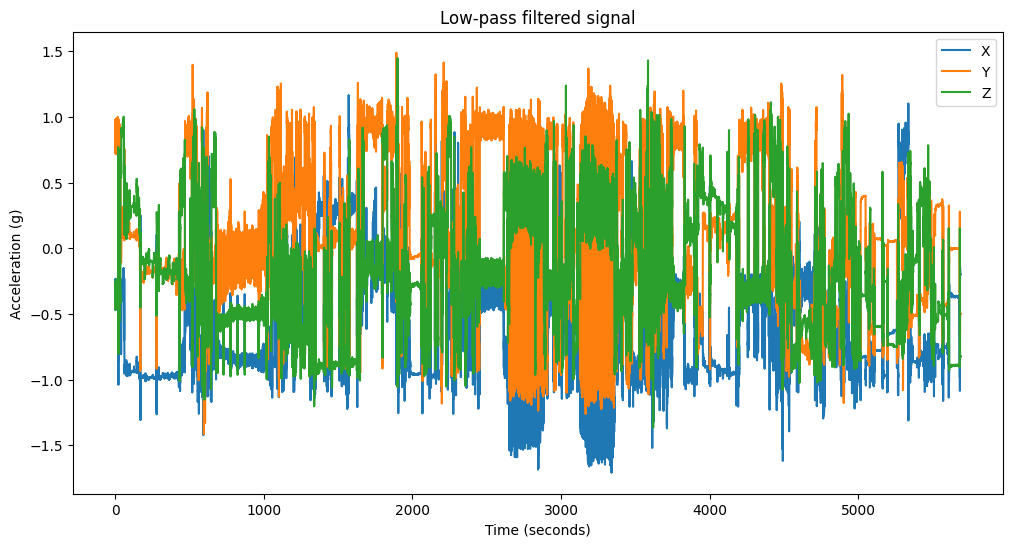

In [ ]:
# Define the sampling frequency (fs) and cutoff frequency for the low-pass filter
fs = 1 / (sampling_interval)  # Sampling frequency in Hz
cutoff = 2  # Low-pass filter cutoff frequency in Hz
axis_labels = ['X', 'Y', 'Z']  # Labels for the signals, used in the plot legend

# Apply the filter directly to the original filtered_data DataFrame 
for signal in signal_columns: 
    data[signal] = lowpass_filter(data[signal], cutoff, fs) # Filter the signal 

# Plot the low-pass filtered signals directly from filtered_data
plt.figure(figsize=(12, 6)) # Set the figure size for better visualization
for signal, axis_label in zip(signal_columns, axis_labels):  # Use axis_labels for legend
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label)  # Plot each filtered signal

# Add plot title, axis labels, and legend
plt.title("Low-pass filtered signal") # Title of the plot
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.legend()  # Display the legend
plt.show()

Nombre total de pics détectés : 3812
Intervalle moyen entre les pics : 1.49 secondes
Cadence moyenne : 106.02 pas par minute


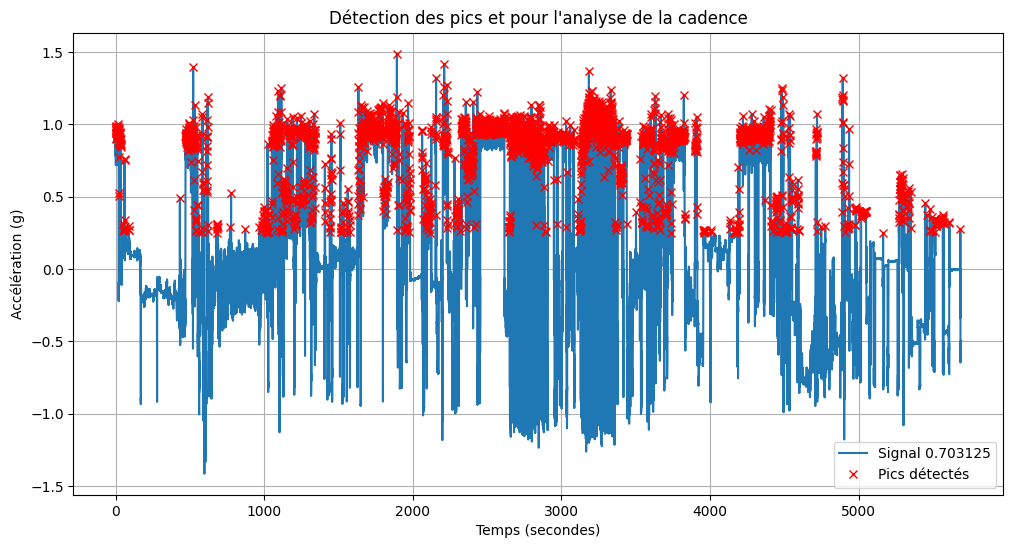

In [ ]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Select the axis (X, Y, or Z) with the highest variance 

signal_columns = data.columns[1:-1]  # Exclude the timestamp and relative time columns
variances = data[signal_columns].var()  # Calculate the variance for each signal column
selected_axis = variances.idxmax()  # Identify the column with the maximum variance

# Detect peaks 
# Parameters 'height' and 'distance' control sensitivity and may require adjustment based on the data
peaks, _ = find_peaks(data[selected_axis], height=0.25, distance=fs*0.1)  # Par exemple, pics à au moins 0.5g et espacés de 0.5 seconde

# Calculate the times of detected peaks 
peak_times = data['relative_time_seconds'].iloc[peaks]

# Compute the intervals between consecutive peaks 
intervals = peak_times.diff().dropna()

# Calculate cadence (steps per second) from the intervals
cadence_per_second = 1 / intervals

# Convert cadence to steps per minute
cadence_per_minute = cadence_per_second * 60

# Display statistics related to the peaks and cadence
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} secondes")
print(f"Cadence moyenne : {cadence_per_minute.mean():.2f} pas par minute")

# Visualize the signal with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_seconds'], data[selected_axis], label=f"Signal {selected_axis}")
plt.plot(peak_times, data[selected_axis].iloc[peaks], "x", label="Pics détectés", color='red') # Highlight peaks
plt.title("Détection des pics et pour l'analyse de la cadence")   # Add a title
plt.xlabel("Temps (secondes)")
plt.ylabel("Accélération (g)")
plt.legend()  # Display the legend
plt.grid(True) # Add grid 
plt.show() # Display the plot